In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [9]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [10]:
m = 100
n = 110

# データ生成
x = np.linspace(0, 1, m)

def one_function(x):
    return np.sin(2 * np.pi * x) + 0.5 * np.cos(4 * np.pi * x)

U = np.zeros((m, n))
for i in range(m):
    U[:, i] = one_function(x)


In [11]:
# 別の正弦波を生成する関数
def generate_sin_wave(x, U):
    S = np.zeros((len(x), U.shape[1]))
    for i in range(U.shape[1]):
        frequency = np.random.uniform(1, 5)  # ランダムな周波数
        phase = np.random.uniform(0, 2 * np.pi)  # ランダムな位相
        amplitude = np.max(np.abs(U[:, i]))  # Uの最大振幅を基準にSの振幅を決定
        S[:, i] = amplitude * np.sin(2 * np.pi * frequency * x + phase)
    return S

S = generate_sin_wave(x, U)

In [12]:
# カスタムDatasetの定義
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, U, x, S):
        self.U = torch.tensor(U, dtype=torch.float32).T
        self.x = torch.tensor(np.tile(x, n).reshape(m * n, 1), dtype=torch.float32)
        self.S = torch.tensor(S, dtype=torch.float32).T.reshape(m * n, 1)

    def __len__(self):
        return len(self.U)

    def __getitem__(self, idx):
        return self.U[idx], self.x[idx], self.S[idx]


In [13]:
# データセットとデータローダーの作成
dataset = CustomDataset(U, x, S)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [14]:
# モデル定義

class ModelB1(nn.Module):
    def __init__(self, in1):
        super(ModelB1, self).__init__()
        self.linear1 = nn.Linear(in1, 20)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(20, 20)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(20, 20)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        return x

class ModelB2(nn.Module):
    def __init__(self):
        super(ModelB2, self).__init__()
        self.linear1 = nn.Linear(1, 20)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(20, 20)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(20, 20)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(20, 20)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        return x

class DeepONet(nn.Module):
    def __init__(self, b1, b2):
        super(DeepONet, self).__init__()
        self.b = torch.nn.parameter.Parameter(torch.tensor(0.0))
        self.b1 = b1
        self.b2 = b2

    def forward(self, x1, x2):
        x1 = self.b1(x1)
        x2 = self.b2(x2)
        x = torch.sum(x1 * x2, dim=1).unsqueeze(1) + self.b
        return x

model_b1 = ModelB1(m).to(device)
model_b2 = ModelB2().to(device)
model = DeepONet(model_b1, model_b2).to(device)
model

DeepONet(
  (b1): ModelB1(
    (linear1): Linear(in_features=100, out_features=20, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=20, out_features=20, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=20, out_features=20, bias=True)
  )
  (b2): ModelB2(
    (linear1): Linear(in_features=1, out_features=20, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=20, out_features=20, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=20, out_features=20, bias=True)
    (relu3): ReLU()
    (linear4): Linear(in_features=20, out_features=20, bias=True)
  )
)

Epoch:    0/500, Loss: 1.043238
Epoch:   50/500, Loss: 1.021444
Epoch:  100/500, Loss: 0.865776
Epoch:  150/500, Loss: 0.883889
Epoch:  200/500, Loss: 0.870526
Epoch:  250/500, Loss: 0.867722
Epoch:  300/500, Loss: 0.898268
Epoch:  350/500, Loss: 0.886885
Epoch:  400/500, Loss: 0.879641
Epoch:  450/500, Loss: 0.898538


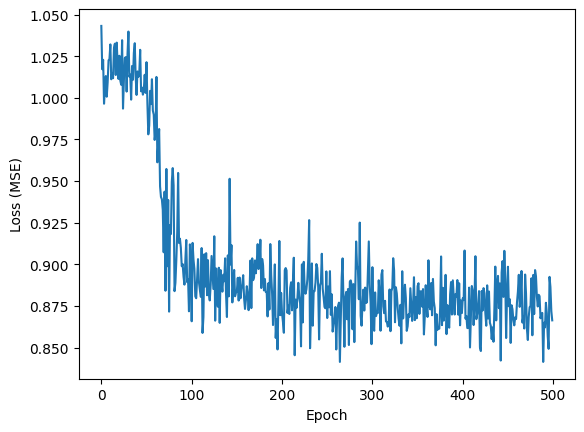

In [15]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 学習
train_losses = []
epochs = 500
for i in range(epochs):
    model.train()
    l_total = 0
    for u_, x_, s_ in train_loader:
        u_, x_, s_ = u_.to(device), x_.to(device), s_.to(device)
        optimizer.zero_grad()
        y_pred = model(u_, x_)
        l = criterion(y_pred, s_)
        l_total += l.item()
        l.backward()
        optimizer.step()
    l_total /= len(train_loader)
    train_losses.append(l_total)
    if i % 50 == 0:
        print(f'Epoch: {i:>4d}/{epochs}, Loss: {l_total:8f}')

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.show()


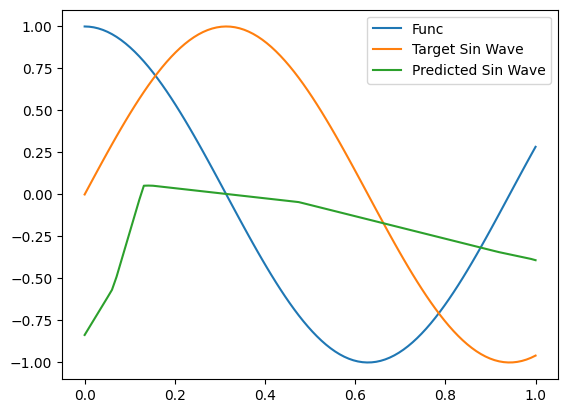

In [16]:
# 検証

x_t = torch.tensor(x, dtype=torch.float32).to(device)
u_t = torch.cos(5 * x_t).cpu().numpy()

# 検証用Sも三角関数で生成
s_t = np.sin(5 * x_t.cpu().numpy())

u_t_ = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0).to(device)
p = model(u_t_, x_t.unsqueeze(1)).cpu().detach().numpy()

plt.plot(x, u_t, label="Func")
plt.plot(x, s_t, label="Target Sin Wave")
plt.plot(x, p, label="Predicted Sin Wave")
plt.legend()
plt.show()